# Bayesian Dynamic TWFE

In [3]:
import re
import pandas as pd
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [4]:
filepath = '../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

## Dynamic TWFE

$$
Y_{it} = \alpha_i + \lambda_t + \sum_{l \in L} \delta_l \mathbf{1}[t - k_i = l] + \epsilon_{it}
$$

ベイズ

$$
\begin{aligned}
\log{Y_{it}} &\sim \mathcal{t}(\nu=3, \mu_{it}, \sigma^2) \\
\mu_{it} &= \text{intercept} + (\beta + \gamma_{\ell}) T_{it} + \text{island}_i + \text{year}_t \\
\sigma &\sim \text{Half-}\mathcal{t}(\nu=3, \sigma=1) \\
\text{intercept} &\sim \mathcal{N}(0, 1) \\
\beta &\sim \mathcal{N}(0, 1) \\
\gamma_{\ell} &\sim \mathcal{N}(\mu_{\gamma}, \sigma_{\gamma}) \\
\text{island}_i &\sim \mathcal{N}(\mu_{\text{island}}, \sigma_{\text{island}}) \\
\text{year}_t &\sim \mathcal{N}(\mu_{\text{year}}, \sigma_{\text{year}}) \\
\mu_{\gamma} &\sim \mathcal{N}(0, 1) \\
\sigma_{\gamma} &\sim \text{Half-}\mathcal{t}(\nu=3, 1) \\
\mu_{\text{island}} &\sim \mathcal{N}(0, 1) \\
\sigma_{\text{island}} &\sim \text{Half-}\mathcal{t}(\nu=3, 1) \\
\mu_{\text{year}} &\sim \mathcal{N}(0, 1) \\
\sigma_{\text{year}} &\sim \text{Half-}\mathcal{t}(\nu=3, 1) \\
\end{aligned}
$$

### ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


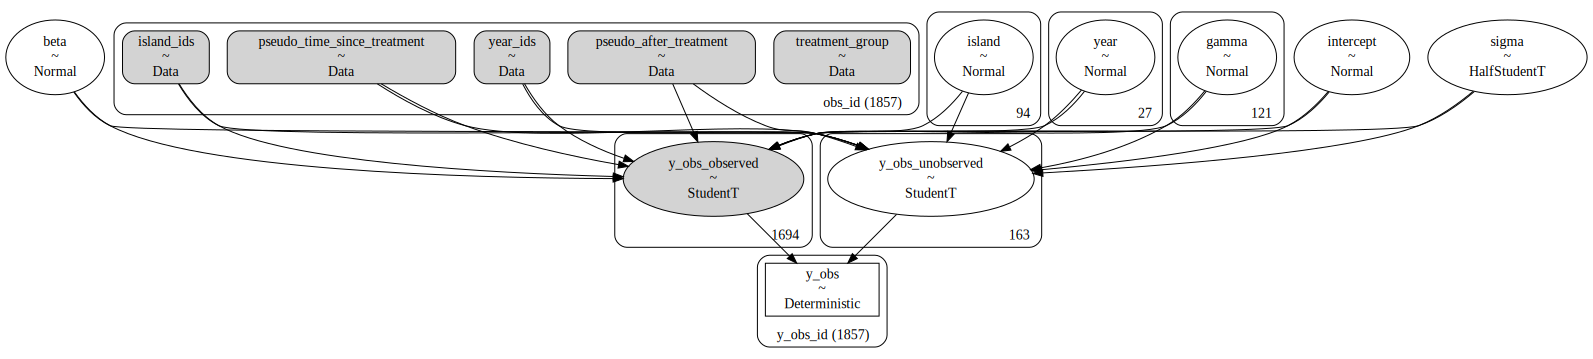

In [5]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['year'], unique_years = pd.factorize(df['year'])
df['pseudo_time_since_treatment'], unique_time_since_treatment = pd.factorize(df['pseudo_time_since_treatment'])

COORDS = {
    'obs_id': df.index,
    'y_obs_id': df.index
}

with pm.Model(coords=COORDS) as dynamic_twfe:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'], dims='obs_id')
    year_ids = pm.Data('year_ids', df['year'], dims='obs_id')
    treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='obs_id')
    pseudo_after_treatment = pm.Data('pseudo_after_treatment', df['pseudo_after_treatment'], dims='obs_id')
    pseudo_time_since_treatment = pm.Data('pseudo_time_since_treatment', df['pseudo_time_since_treatment'], dims='obs_id')

    # priors
    # random effect
    island = pm.Normal('island', mu=0, sigma=1, shape=len(unique_island_ids))
    year = pm.Normal('year', mu=0, sigma=1, shape=len(unique_years))
    # 時間変動の介入効果
    gamma = pm.Normal(
        'gamma', mu=0, sigma=1,
        shape=len(unique_time_since_treatment)
    )

    # fixed effect
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1) # 時間固定の介入効果
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=1)

    # expectation
    mu = intercept + (beta + gamma[pseudo_time_since_treatment]) * pseudo_after_treatment + island[island_ids] + year[year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['log_pop'], dims='y_obs_id')

pm.model_to_graphviz(dynamic_twfe)

In [5]:
with dynamic_twfe:
    initvals = {'intercept': 5, 'beta': 0.4, 'sigma': 0.1}
    trace_dynamic_twfe = pm.sample(
        draws=3000,
        tune=1000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
        initvals=initvals
    )
    pm.compute_log_likelihood(trace_dynamic_twfe)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [6]:
az.summary(
    trace_dynamic_twfe,
    var_names=['intercept', 'beta', 'sigma'],
    hdi_prob=0.95
)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,5.652,0.209,5.250,6.070,0.018,0.013,138.0,429.0,1.00
beta,0.476,0.128,0.210,0.720,0.010,0.007,170.0,359.0,1.01
sigma,0.111,0.003,0.105,0.117,0.000,0.000,4612.0,3950.0,1.00


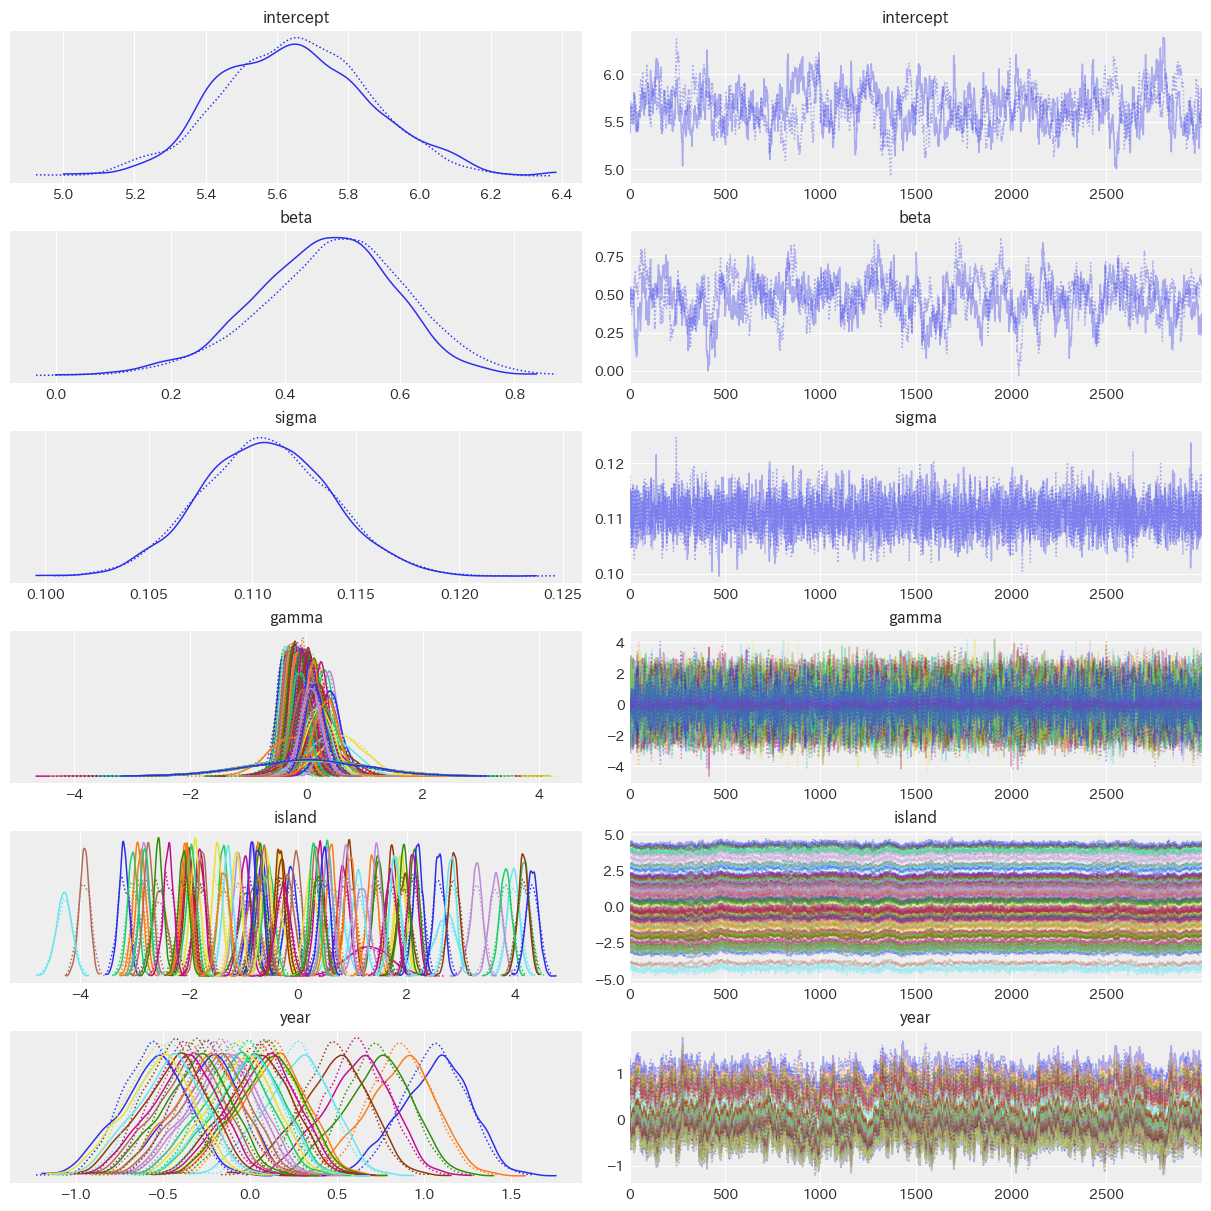

In [20]:
az.plot_trace(
    trace_dynamic_twfe,
    var_names=['intercept', 'beta', 'sigma', 'gamma', 'island', 'year']
);

In [31]:
def get_mean_and_sd_of_random_effects(trace, var_name):
    df_ = az.summary(trace, var_names=[f'{var_name}'], hdi_prob=0.95, kind='stats')
    mu_mean = np.mean(df_['mean'])
    mu_sd = np.std(df_['mean'])
    sigma_mean = np.mean(df_['sd'])
    sigma_sd = np.std(df_['sd'])
    return mu_mean, mu_sd, sigma_mean, sigma_sd

In [40]:
mu_mean_island, mu_sd_island, sigma_mean_island, sigma_sd_island = get_mean_and_sd_of_random_effects(trace_dynamic_twfe, 'island')
mu_mean_year, mu_sd_year, sigma_mean_year, sigma_sd_year = get_mean_and_sd_of_random_effects(trace_dynamic_twfe, 'year')
mu_mean_gamma, mu_sd_gamma, sigma_mean_gamma, sigma_sd_gamma = get_mean_and_sd_of_random_effects(trace_dynamic_twfe, 'gamma')

print(f'island mu: {mu_mean_island:.3f}, ({mu_sd_island:.3f})')
print(f'island sigma: {sigma_mean_island:.3f}, ({sigma_sd_island:.3f})')
print(f'year mu: {mu_mean_year:.3f}, ({mu_sd_year:.3f})')
print(f'year sigma: {sigma_mean_year:.3f}, ({sigma_sd_year:.3f})')
print(f'gamma mu: {mu_mean_gamma:.3f}, ({mu_sd_gamma:.3f})')
print(f'gamma sigma: {sigma_mean_gamma:.3f}, ({sigma_sd_gamma:.3f})')

island mu: -0.012, (1.985)
island sigma: 0.118, (0.034)
year mu: 0.006, (0.419)
year sigma: 0.191, (0.001)
gamma mu: 0.001, (0.168)
gamma sigma: 0.501, (0.406)


In [19]:
az.waic(trace_dynamic_twfe)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 6000 posterior samples and 1694 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   445.16    56.61
p_waic      206.16        -

There has been a warning during the calculation. Please check the results.

### 階層ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


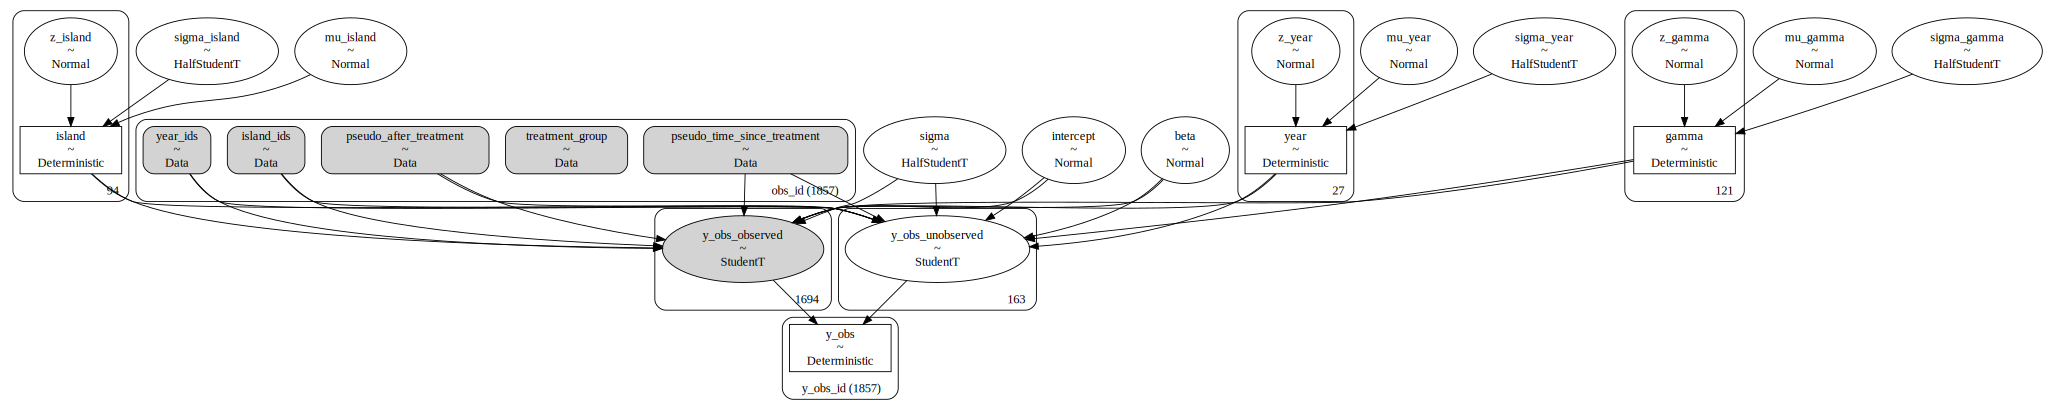

In [50]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['year'], unique_years = pd.factorize(df['year'])
df['pseudo_time_since_treatment'], unique_time_since_treatment = pd.factorize(df['pseudo_time_since_treatment'])

COORDS = {
    'obs_id': df.index,
    'y_obs_id': df.index
}

with pm.Model(coords=COORDS) as dynamic_twfe_h:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'], dims='obs_id')
    year_ids = pm.Data('year_ids', df['year'], dims='obs_id')
    treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='obs_id')
    pseudo_after_treatment = pm.Data('pseudo_after_treatment', df['pseudo_after_treatment'], dims='obs_id')
    pseudo_time_since_treatment = pm.Data('pseudo_time_since_treatment', df['pseudo_time_since_treatment'], dims='obs_id')

    # priors
    # random effect
    mu_island = pm.Normal('mu_island', mu=0, sigma=10)
    sigma_island = pm.HalfStudentT('sigma_island', nu=3, sigma=10)
    z_island = pm.Normal('z_island', mu=0, sigma=1, shape=len(unique_island_ids))
    island = pm.Deterministic('island', mu_island + sigma_island * z_island)

    mu_year = pm.Normal('mu_year', mu=0, sigma=10)
    sigma_year = pm.HalfStudentT('sigma_year', nu=3, sigma=10)
    z_year = pm.Normal('z_year', mu=0, sigma=1, shape=len(unique_years))
    year = pm.Deterministic('year', mu_year + sigma_year * z_year)

    mu_gamma = pm.Normal('mu_gamma', mu=0, sigma=10)
    sigma_gamma = pm.HalfStudentT('sigma_gamma', nu=3, sigma=10)
    z_gamma = pm.Normal('z_gamma', mu=0, sigma=1, shape=len(unique_time_since_treatment))
    gamma = pm.Deterministic('gamma', mu_gamma + sigma_gamma * z_gamma)

    # fixed effect
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1) # 時間固定の介入効果
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=1)

    # expectation
    mu = intercept + (beta + gamma[pseudo_time_since_treatment]) * pseudo_after_treatment + island[island_ids] + year[year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['log_pop'], dims='y_obs_id')

pm.model_to_graphviz(dynamic_twfe_h)

In [ ]:
with dynamic_twfe_h:
    initvals = {'intercept': 2, 'beta': 0.4, 'sigma': 0.1}
    trace_dynamic_twfe_h = pm.sample(
        draws=5000,
        tune=2000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
        initvals=initvals
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [52]:
az.summary(
    trace_dynamic_twfe_h,
    var_names=['intercept', 'beta', 'sigma'],
    hdi_prob=0.95
)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,3.176,7.482,-10.837,20.131,3.066,2.284,6.0,13.0,1.25
beta,-0.167,0.918,-2.197,1.531,0.270,0.196,11.0,17.0,1.16
sigma,0.112,0.003,0.107,0.119,0.001,0.000,34.0,73.0,1.08


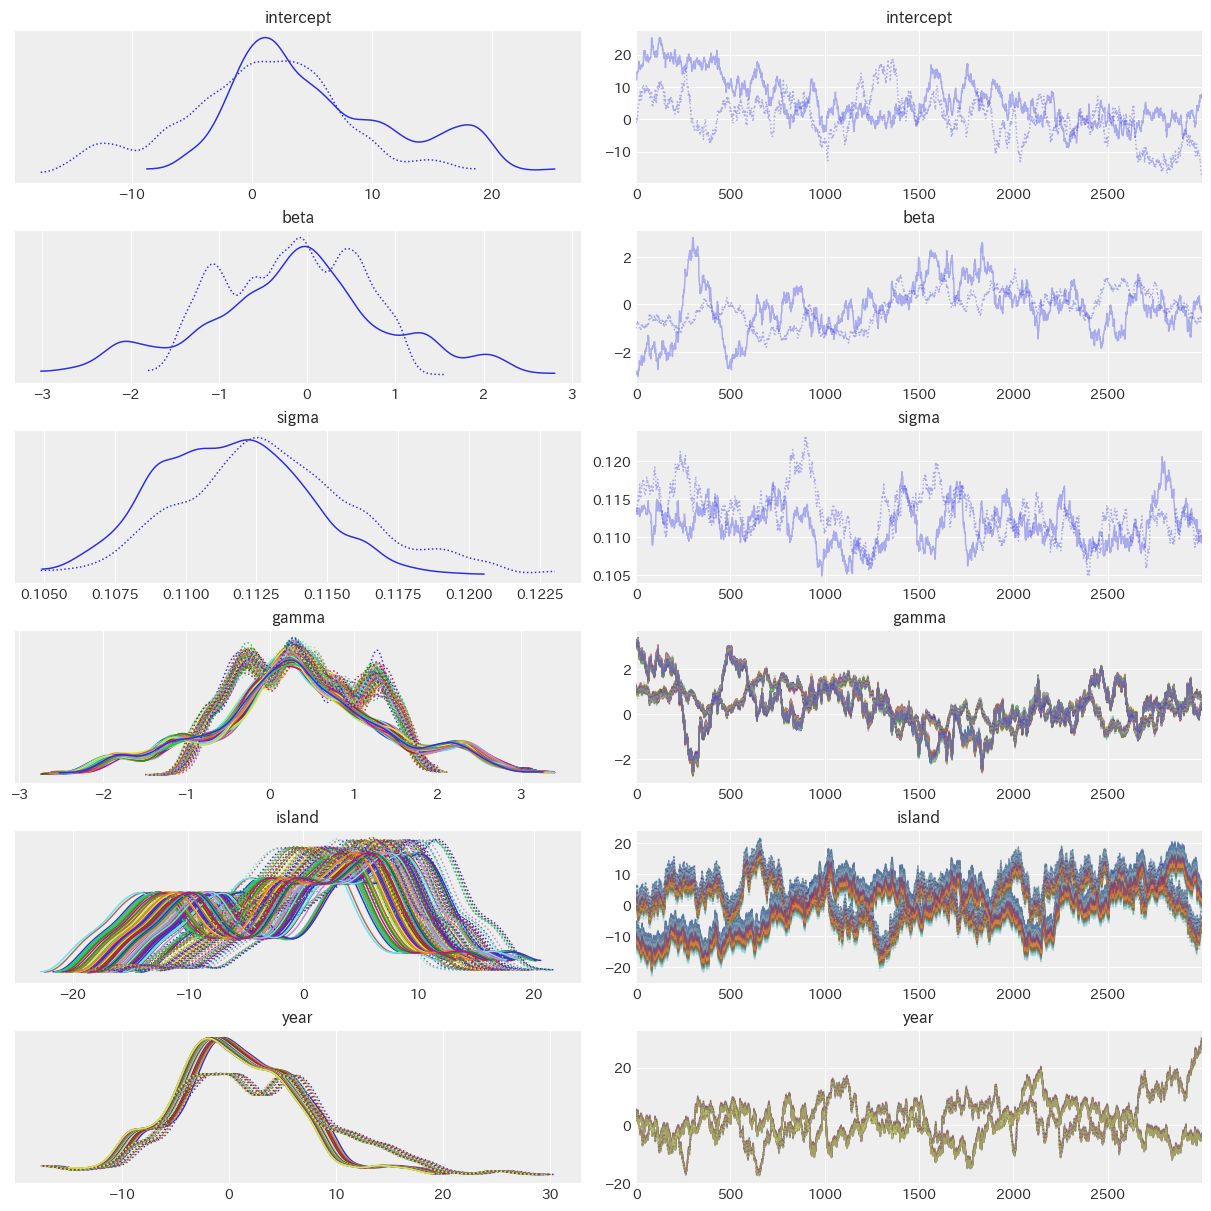

In [53]:
az.plot_trace(
    trace_dynamic_twfe_h,
    var_names=['intercept', 'beta', 'sigma', 'gamma', 'island', 'year']
);

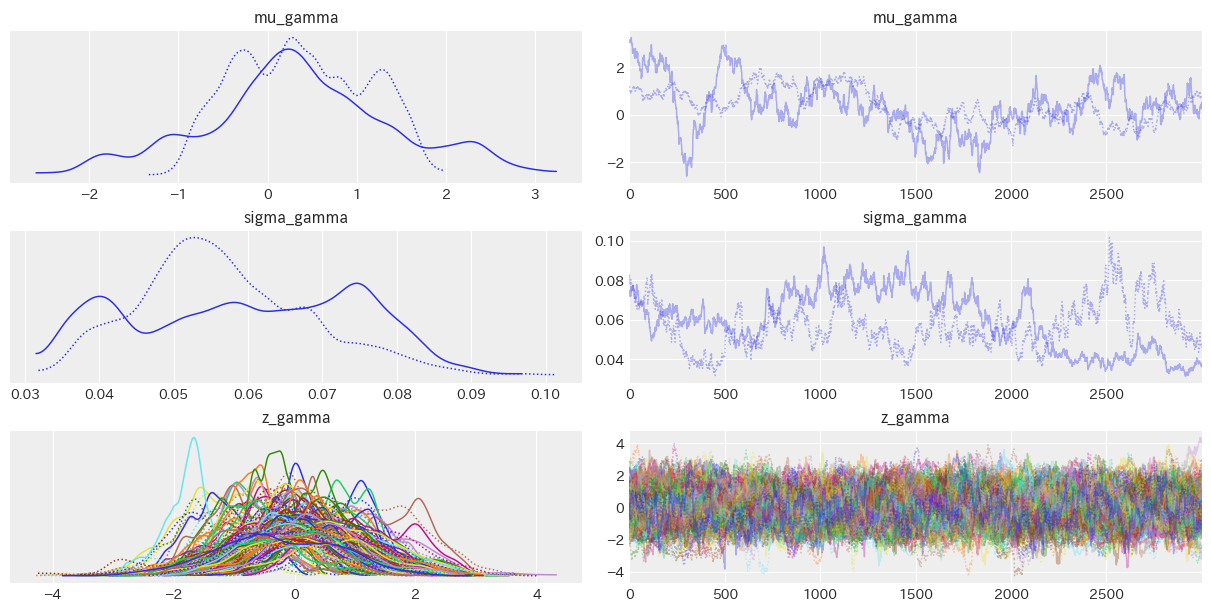

In [56]:
az.plot_trace(
    trace_dynamic_twfe_h,
    var_names=['mu_gamma', 'sigma_gamma', 'z_gamma']
);

In [55]:
with dynamic_twfe_h:
    pm.compute_log_likelihood(trace_dynamic_twfe_h)

az.waic(trace_dynamic_twfe_h)

Output()

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 6000 posterior samples and 1694 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   447.08    56.88
p_waic      163.32        -

There has been a warning during the calculation. Please check the results.

## サンプリングの保存

In [66]:
# az.to_netcdf(trace_dynamic_twfe, './sample/trace_dynamic_twfe_log.nc')
# az.to_netcdf(trace_dynamic_twfe_h, './sample/trace_dynamic_twfe_h_log.nc')

OSError: Unable to synchronously create file (unable to truncate a file which is already open)

## サンプリングのインポート

In [ ]:
# trace_dynamic_twfe = az.from_netcdf('./sample/trace_dynamic_twfe_log.nc')
# trace_dynamic_twfe_h = az.from_netcdf('./sample/trace_dynamic_twfe_h_log.nc')

## 時間変動のプロット

In [64]:
def get_beta_df(trace):
    # ベータのサマリーを取得
    beta_df = az.summary(trace, var_names=['beta'], hdi_prob=0.95, kind='stats')
    mu_beta = beta_df['mean']
    return beta_df, mu_beta

def get_gamma_df(trace):
    # デルタのサマリーを取得
    gamma_df = az.summary(trace, var_names=['gamma'], hdi_prob=0.95, kind='stats')

    # 経過年数
    df = pd.read_excel(filepath)
    pseudo_time_since_intervention_list = df['pseudo_time_since_treatment'].unique()
    pseudo_time_since_intervention_df = pd.DataFrame(pseudo_time_since_intervention_list, columns=['pseudo_time_since_treatment'])

    # デルタの値を経過年数と結合
    # デルタの順番は経過年数の昇順ではなく，データに登場した順番になっている．
    gamma_df.reset_index(drop=True, inplace=True)
    gamma_df = pd.concat([gamma_df, pseudo_time_since_intervention_df], axis=1)

    gamma_df['exp_mean'] = np.exp(gamma_df['mean']) - 1
    gamma_df['exp_hdi_2.5%'] = np.exp(gamma_df['hdi_2.5%']) - 1
    gamma_df['exp_hdi_97.5%'] = np.exp(gamma_df['hdi_97.5%']) - 1

    return gamma_df

def plot_random_effects(gamma_df, exp=False):
    plt.figure(figsize=(12, 6))
    if exp:
        mean = 'exp_mean'
        hdi_2_5 = 'exp_hdi_2.5%'
        hdi_97_5 = 'exp_hdi_97.5%'
        plt.ylim(-1, 1)
        log_or_percent = '%'
        log_or_exp = '指数'
    else:
        mean = 'mean'
        hdi_2_5 = 'hdi_2.5%'
        hdi_97_5 = 'hdi_97.5%'
        plt.ylim(-0.5, 1)
        log_or_percent = '対数値'
        log_or_exp = '対数'


    sns.lineplot(
        x='pseudo_time_since_treatment',
        y=mean,
        data=gamma_df,
        marker='o',
        color='black',
        label='事後期待値'
    )
    # エラーバー
    plt.errorbar(
        x=gamma_df['pseudo_time_since_treatment'],
        y=gamma_df[mean],
        yerr=[
            gamma_df[mean] - gamma_df[hdi_2_5],
            gamma_df[hdi_97_5] - gamma_df[mean]
        ],
        fmt='o',
        color='black',
        alpha=0.5,
        capsize=5,
        label='95% 信用区間'
    )
    plt.axvline(x=0, color='red', linestyle='-')
    plt.axhline(y=0, color='red', linestyle='-')
    plt.xlabel('経過年数')
    plt.ylabel(f'ランダム効果({log_or_percent})')
    plt.title(f'時間変動のランダム効果({log_or_exp})')
    plt.legend()
    plt.show()

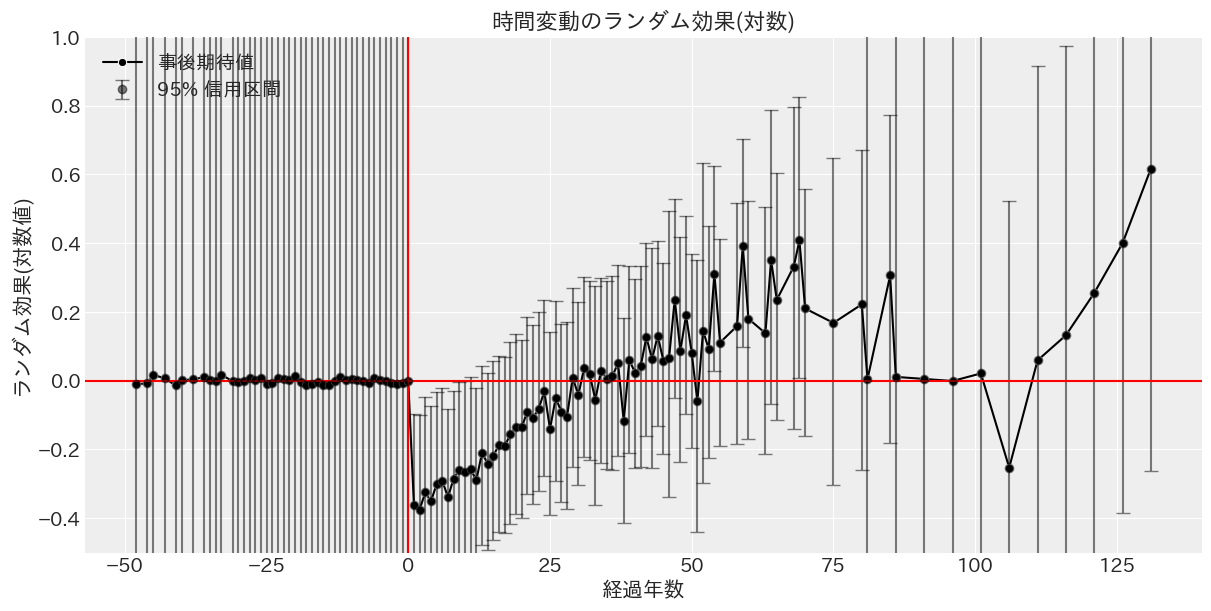

In [65]:
gamma_df = get_gamma_df(trace_dynamic_twfe)
plot_random_effects(gamma_df, exp=False)

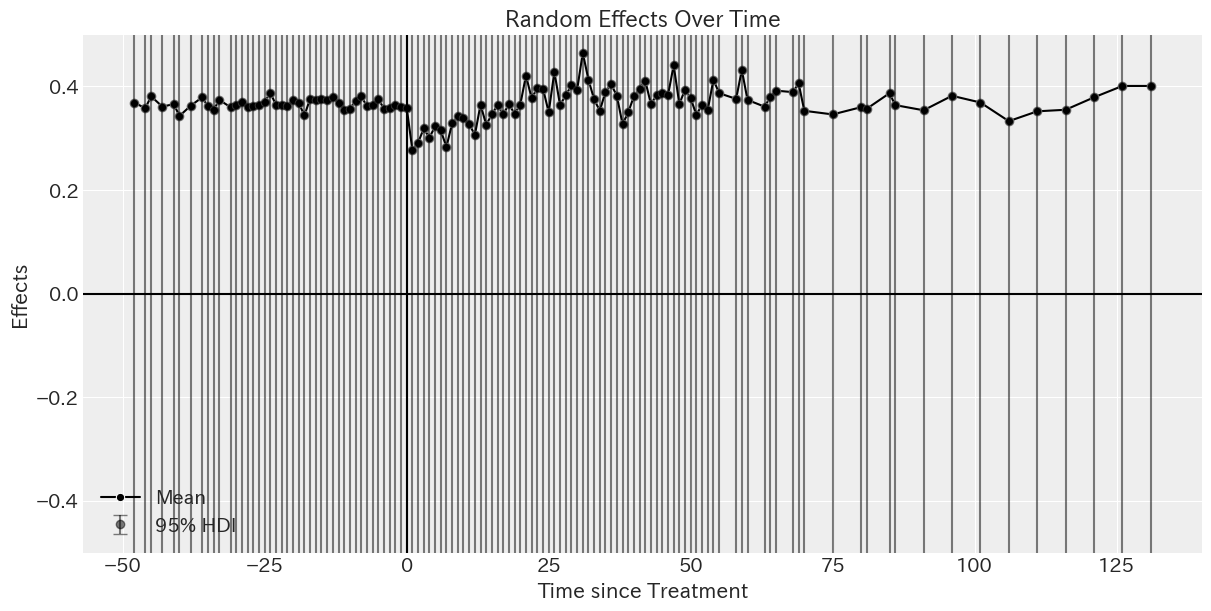

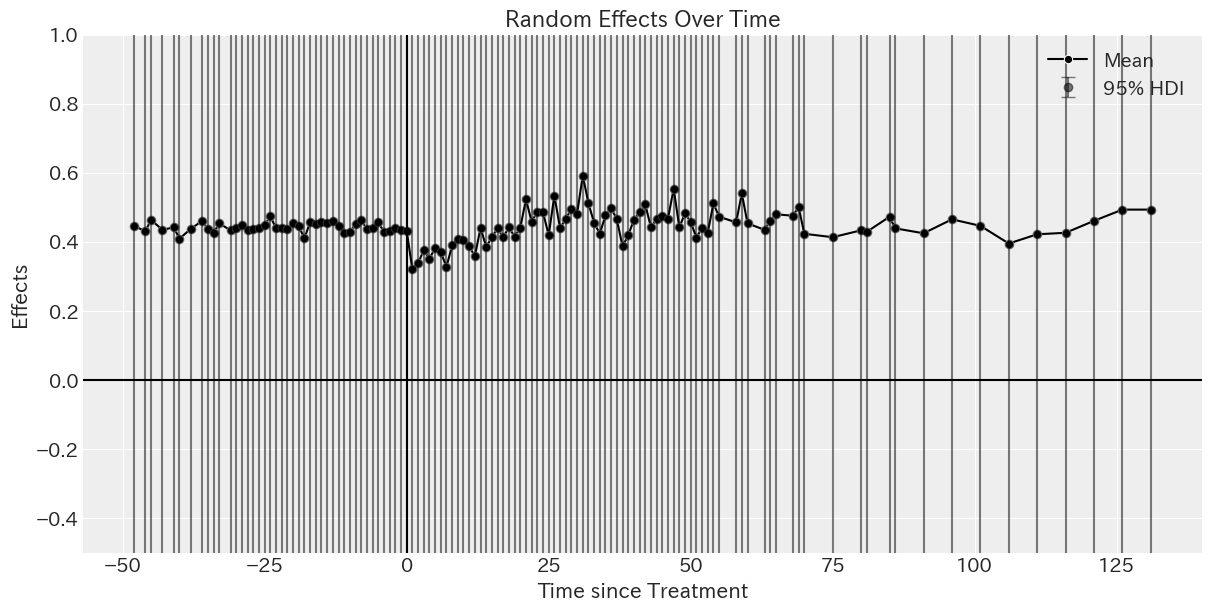

In [ ]:
gamma_df = get_gamma_df(trace_dynamic_twfe_h)
plot_random_effects(gamma_df)